# Fish sleep and bacteria growth: A review of Statistical Thinking I and II

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

## EDA: Plot ECDFs of active bout length

An active bout is a stretch of time where a fish is constantly moving. Plot an ECDF of active bout length for the mutant and wild type fish for the seventh night of their lives. The data sets are in the numpy arrays bout_lengths_wt and bout_lengths_mut. The bout lengths are in units of minutes.

In [18]:
bout_lengths_wt = np.loadtxt('27Data1.txt', delimiter=',')
bout_lengths_mut = np.loadtxt('27Data2.txt', delimiter=',')

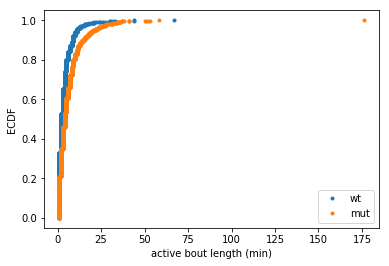

In [19]:
# Import the dc_stat_think module as dcst
import dc_stat_think as dcst

# Generate x and y values for plotting ECDFs
x_wt, y_wt = dcst.ecdf(bout_lengths_wt)
x_mut, y_mut = dcst.ecdf(bout_lengths_mut)

# Plot the ECDFs
_ = plt.plot(x_wt, y_wt, marker='.', linestyle='none')
_ = plt.plot(x_mut, y_mut, marker='.', linestyle='none')

# Make a legend, label axes, and show plot
_ = plt.legend(('wt', 'mut'))
_ = plt.xlabel('active bout length (min)')
_ = plt.ylabel('ECDF')
plt.show()


## Interpreting ECDFs and the story

While a more detailed analysis of distributions is often warranted for careful analyses, you can already get a feel for the distributions and the story behind the data by eyeballing the ECDFs. Which of the following would be the most reasonable statement to make about how the active bout lengths are distributed and what kind of process might be behind exiting the active bout to rest?

If you need a refresher, here are videos from Statistical Thinking I about stories behind probability distributions.

    Discrete Uniform and Binomial
    Poisson processes and Poisson distribution
    Normal distribution
    Exponential Distribution


## Parameter estimation: active bout length

Compute the mean active bout length for wild type and mutant, with 95% bootstrap confidence interval. The data sets are again available in the numpy arrays bout_lengths_wt and bout_lengths_mut. The dc_stat_think module has been imported as dcst.

In [20]:
# Compute mean active bout length
mean_wt = np.mean(bout_lengths_wt)
mean_mut = np.mean(bout_lengths_mut)

# Draw bootstrap replicates
bs_reps_wt = dcst.draw_bs_reps(bout_lengths_wt, np.mean, size=10000)
bs_reps_mut = dcst.draw_bs_reps(bout_lengths_mut, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_wt = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mut = np.percentile(bs_reps_mut, [2.5, 97.5])

# Print the results
print("""
wt:  mean = {0:.3f} min., conf. int. = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., conf. int. = [{4:.1f}, {5:.1f}] min.
""".format(mean_wt, *conf_int_wt, mean_mut, *conf_int_mut))


wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.



## Permutation test: wild type versus heterozygote

Test the hypothesis that the heterozygote and wild type bout lengths are identically distributed using a permutation test.

In [22]:
bout_lengths_het = np.loadtxt('27Data3.txt', delimiter=',')

In [23]:
# Compute the difference of means: diff_means_exp
diff_means_exp = np.mean(bout_lengths_het) - np.mean(bout_lengths_wt)

# Draw permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(bout_lengths_het, bout_lengths_wt, 
                               dcst.diff_of_means, size=10000)

# Compute the p-value: p_val
p_val = np.sum(perm_reps >= diff_means_exp) / len(perm_reps)

# Print the result
print('p =', p_val)

p = 0.0008


## Bootstrap hypothesis test

The permutation test has a pretty restrictive hypothesis, that the heterozygotic and wild type bout lengths are identically distributed. Now, use a bootstrap hypothesis test to test the hypothesis that the means are equal, making no assumptions about the distributions.

In [24]:
# Concatenate arrays: bout_lengths_concat
bout_lengths_concat = np.concatenate((bout_lengths_wt, bout_lengths_het))

# Compute mean of all bout_lengths: mean_bout_length
mean_bout_length = np.mean(bout_lengths_concat)

# Generate shifted arrays
wt_shifted = bout_lengths_wt - np.mean(bout_lengths_wt) + mean_bout_length
het_shifted = bout_lengths_het - np.mean(bout_lengths_het) + mean_bout_length

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_wt = dcst.draw_bs_reps(wt_shifted, np.mean, size=10000)
bs_reps_het = dcst.draw_bs_reps(het_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_reps
bs_reps = bs_reps_het - bs_reps_wt

# Compute and print p-value: p
p = np.sum(bs_reps >= diff_means_exp) / len(bs_reps)
print('p-value =', p)

p-value = 0.0006


## Assessing the growth rate

To compute the growth rate, you can do a linear regression of the logarithm of the total bacterial area versus time. Compute the growth rate and get a 95% confidence interval using pairs bootstrap. The time points, in units of hours, are stored in the numpy array t and the bacterial area, in units of square micrometers, is stored in bac_area.

In [29]:
bac_area = np.array([  5.574735  ,   5.71202325,   5.90339475,   6.19461225,
         6.456708  ,   6.85193175,   7.17643125,   7.56749475,
         8.087526  ,   8.586756  ,   8.74900575,   9.48120975,
        10.03868325,  10.550394  ,  11.13698925,  11.765187  ,
        12.38506425,  13.07566575,  13.7371455 ,  14.377824  ,
        14.89785525,  15.5177325 ,  16.341462  ,  17.31912075,
        18.4132665 ,  19.5947775 ,  20.96766   ,  22.07844675,
        23.41804725,  24.6702825 ,  26.25533775,  28.00264275,
        29.6293005 ,  31.41404775,  33.31944225,  35.59925925,
        37.974762  ,  40.787091  ,  43.749189  ,  46.8028125 ,
        50.28494175,  53.467533  ,  57.644424  ,  61.438572  ,
        64.72932975,  68.3861895 ,  71.539659  ,  75.85383825,
        81.61994475,  86.050611  ,  91.53798075,  98.231823  ,
       104.27666625, 110.862342  , 118.31751   ])
t = np.array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 ])

In [30]:
# Compute logarithm of the bacterial area
log_bac_area = np.log(bac_area)

# Compute the slope and intercept: growth_rate, log_a0
growth_rate, log_a0 = np.polyfit(t, log_bac_area, 1)

# Draw 10,000 pairs bootstrap replicates: growth_rate_bs_reps, log_a0_bs_reps
growth_rate_bs_reps, log_a0_bs_reps = \
            dcst.draw_bs_pairs_linreg(t, log_bac_area, size=10000)
    
# Compute confidence intervals: growth_rate_conf_int
growth_rate_conf_int = np.percentile(growth_rate_bs_reps, [2.5, 97.5])

# Print the result to the screen
print("""
Growth rate: {0:.4f} sq. µm/hour
95% conf int: [{1:.4f}, {2:.4f}] sq. µm/hour
""".format(growth_rate, *growth_rate_conf_int))


Growth rate: 0.2301 sq. µm/hour
95% conf int: [0.2266, 0.2336] sq. µm/hour



## Plotting the growth curve

You saw in the previous exercise that the confidence interval on the growth curve is very tight. You will explore this graphically here by plotting several bootstrap lines along with the growth curve. You will use the plt.semilogy() function to make the plot with the y-axis on a log scale. This means that you will need to transform your theoretical linear regression curve for plotting by exponentiating it.

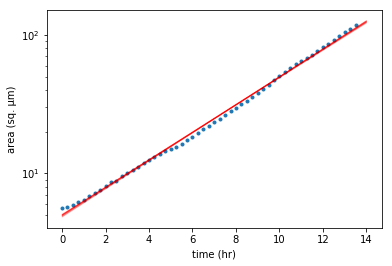

In [31]:
# Plot data points in a semilog-y plot with axis labeles
_ = plt.semilogy(t, bac_area, marker='.', linestyle='none')

# Generate x-values for the bootstrap lines: t_bs
t_bs = np.array([0, 14])

# Plot the first 100 bootstrap lines
for i in range(100):
    y = np.exp(growth_rate_bs_reps[i] * t_bs + log_a0_bs_reps[i])
    _ = plt.semilogy(t_bs, y, linewidth=0.5, alpha=0.05, color='red')
    
# Label axes and show plot
_ = plt.xlabel('time (hr)')
_ = plt.ylabel('area (sq. µm)')
plt.show()

# Analysis of results of the 2015 FINA World Swimming Championships

## Graphical EDA of men's 200 free heats

In the heats, all contestants swim, the very fast and the very slow. To explore how the swim times are distributed, plot an ECDF of the men's 200 freestyle.

In [33]:
mens_200_free_heats = np.array([118.32, 107.73, 107.  , 106.39, 108.75, 117.74, 108.43, 111.96,
       114.36, 121.77, 108.23, 107.47, 118.41, 108.29, 106.  , 109.32,
       111.49, 112.92, 117.38, 110.95, 108.27, 111.78, 107.87, 110.77,
       109.05, 111.  , 108.77, 106.1 , 106.61, 113.68, 108.2 , 106.2 ,
       111.01, 109.25, 112.  , 118.55, 109.56, 108.18, 111.67, 108.09,
       110.04, 113.97, 109.91, 112.12, 111.65, 110.18, 116.36, 124.59,
       115.59, 121.01, 106.88, 108.96, 109.09, 108.67, 109.6 , 111.85,
       118.54, 108.12, 124.38, 107.17, 107.48, 106.65, 106.91, 140.68,
       117.93, 120.66, 111.29, 107.1 , 108.49, 112.43, 110.61, 110.38,
       109.87, 106.73, 107.18, 110.98, 108.55, 114.31, 112.05])

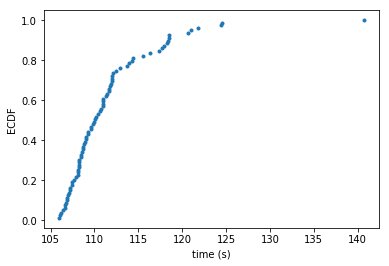

In [34]:
# Generate x and y values for ECDF
x, y = dcst.ecdf(mens_200_free_heats)

# Plot the ECDF as dots
_ = plt.plot(x, y, marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('time (s)')
_ = plt.ylabel('ECDF')
plt.show()


## 200 m free time with confidence interval

Now, you will practice parameter estimation and computation of confidence intervals by computing the mean and median swim time for the men's 200 freestyle heats. The median is useful because it is immune to heavy tails in the distribution of swim times, such as the slow swimmers in the heats. mens_200_free_heats is still in your namespace.

In [35]:
# Compute mean and median swim times
mean_time = np.mean(mens_200_free_heats)
median_time = np.median(mens_200_free_heats)

# Draw 10,000 bootstrap replicates of the mean and median
bs_reps_mean = dcst.draw_bs_reps(mens_200_free_heats, np.mean, size=10000)
bs_reps_median = dcst.draw_bs_reps(mens_200_free_heats, np.median, size=10000)


# Compute the 95% confidence intervals
conf_int_mean = np.percentile(bs_reps_mean, [2.5, 97.5])
conf_int_median = np.percentile(bs_reps_median, [2.5, 97.5])

# Print the result to the screen
print("""
mean time: {0:.2f} sec.
95% conf int of mean: [{1:.2f}, {2:.2f}] sec.

median time: {3:.2f} sec.
95% conf int of median: [{4:.2f}, {5:.2f}] sec.
""".format(mean_time, *conf_int_mean, median_time, *conf_int_median))


mean time: 111.63 sec.
95% conf int of mean: [110.46, 112.91] sec.

median time: 110.04 sec.
95% conf int of median: [108.96, 111.02] sec.



## EDA: finals versus semifinals

First, you will get an understanding of how athletes' performance changes from the semifinals to the finals by computing the fractional improvement from the semifinals to finals and plotting an ECDF of all of these values.

The arrays final_times and semi_times contain the swim times of the respective rounds. The arrays are aligned such that final_times[i] and semi_times[i] are for the same swimmer/event. If you are interested in the strokes/events, you can check out the data frame df in your namespace, which has more detailed information, but is not used in the analysis.

In [39]:
semi_times = np.array([ 53.  ,  24.32,  52.84,  24.22,  57.59, 116.95,  58.56,  27.7 ,
       126.56,  59.05,  27.83, 127.57,  25.81,  24.38,  27.41,  58.05,
       128.99,  24.52,  57.52, 142.82, 128.16,  31.03,  59.33,  27.18,
        57.63,  66.28, 143.06,  57.36,  25.79, 116.44,  53.91, 127.08,
        27.67, 127.69, 141.99,  57.04,  25.27,  58.84,  27.63,  25.88,
       142.9 ,  25.71,  24.5 ,  59.71,  27.88,  57.77, 126.64, 129.16,
        28.01, 116.51, 126.18, 127.05, 129.04,  67.11,  30.9 , 116.23,
        66.95,  66.21,  30.78, 126.36,  66.64, 142.15, 142.88,  65.64,
        29.98, 116.91,  53.38,  53.78,  24.23,  25.9 ,  25.91, 116.56,
       128.74,  65.6 ,  30.14,  59.55, 142.72,  55.74,  52.78,  25.06,
        24.31,  66.76,  30.39,  30.64,  53.81,  24.47, 142.04, 116.76,
        59.42, 116.37,  53.92, 127.79,  30.25, 127.52,  59.63, 127.57])
final_times = np.array([ 52.52,  24.12,  52.82,  24.36,  57.67, 116.41,  58.26,  27.66,
       125.81,  58.75,  27.92, 126.78,  25.93,  24.44,  27.26,  58.22,
       128.66,  24.39,  57.69, 143.61, 128.51,  30.74,  59.02,  27.11,
        57.85,  66.55, 142.76,  57.48,  25.37, 116.27,  54.76, 126.51,
        27.58, 130.2 , 142.76,  57.05,  25.34,  58.86,  27.73,  25.78,
       142.76,  25.85,  24.51,  59.78,  27.99,  57.94, 126.78, 128.49,
        28.17, 116.19, 126.84, 127.76, 129.53,  67.1 ,  31.12, 115.32,
        67.6 ,  66.42,  30.11, 125.56,  66.43, 141.15, 143.19,  66.36,
        30.14, 116.79,  53.58,  53.17,  24.22,  25.64,  26.2 , 116.16,
       127.64,  65.66,  30.13,  59.66, 143.59,  55.64,  52.7 ,  24.96,
        24.31,  67.17,  30.05,  31.14,  53.93,  24.57, 142.44, 115.16,
        59.4 , 115.49,  54.  , 126.34,  30.2 , 126.95,  59.99, 126.4 ])

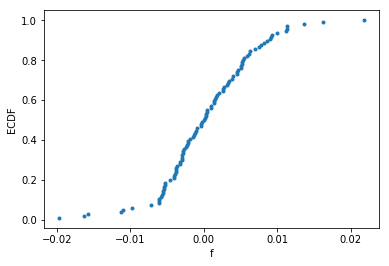

In [40]:
# Compute fractional difference in time between finals and semis
f = (semi_times - final_times) / semi_times

# Generate x and y values for the ECDF: x, y
x, y = dcst.ecdf(f)

# Make a plot of the ECDF
_ = plt.plot(x, y, marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('f')
_ = plt.ylabel('ECDF')
plt.show()

## Parameter estimates of difference between finals and semifinals

Compute the mean fractional improvement from the semifinals to finals, along with a 95% confidence interval of the mean. The Numpy array f that you computed in the last exercise is in your namespace.

In [41]:
# Mean fractional time difference: f_mean
f_mean = np.mean(f)

# Get bootstrap reps of mean: bs_reps
bs_reps = dcst.draw_bs_reps(f, np.mean, size=10000)

# Compute confidence intervals: conf_int
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Report
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))



mean frac. diff.: 0.00040
95% conf int of mean frac. diff.: [-0.00092, 0.00174]


## How to do the permutation test

Based on our EDA and parameter estimates, it is tough to discern improvement from the semifinals to finals. In the next exercise, you will test the hypothesis that there is no difference in performance between the semifinals and finals. A permutation test is fitting for this. We will use the mean value of f as the test statistic. Which of the following simulates getting the test statistic under the null hypothesis?

    Strategy 1
    Take an array of semifinal times and an array of final times for each swimmer for each stroke/distance pair.
    Go through each array, and for each index, swap the entry in the respective final and semifinal array with a 50% probability.
    Use the resulting final and semifinal arrays to compute f and then the mean of f.
    Strategy 2
    Take an array of semifinal times and an array of final times for each swimmer for each stroke/distance pair and concatenate them, giving a total of 96 entries.
    Scramble the concatenated array using the np.permutation() function. Assign the first 48 entries in the scrambled array to be "semifinal" and the last 48 entries to be "final."
    Compute f from these new semifinal and final arrays, and then compute the mean of f.
    Strategy 3
    Take the array f we used in the last exercise.
    Multiply each entry of f by either 1 or -1 with equal probability.
    Compute the mean of this new array to get the test statistic.
    Strategy 4
    Define a function with signature compute_f(semi_times, final_times) to compute f from inputted swim time arrays.
    Draw a permutation replicate using dcst.draw_perm_reps(semi_times, final_times, compute_f).


## Generating permutation samples

As you worked out in the last exercise, we need to generate a permutation sample by randomly swapping corresponding entries in the semi_times and final_times array. Write a function with signature swap_random(a, b) that returns arrays where random indices have the entries in a and b swapped.

In [43]:
def swap_random(a, b):
    """Randomly swap entries in two arrays."""
    # Indices to swap
    swap_inds = np.random.random(size=len(a)) < 0.5
    
    # Make copies of arrays a and b for output
    a_out = np.copy(a)
    b_out = np.copy(b)
    
    # Swap values
    a_out[swap_inds] = b[swap_inds]
    b_out[swap_inds] = a[swap_inds]

    return a_out, b_out

## Hypothesis test: Do women swim the same way in semis and finals?

Test the hypothesis that performance in the finals and semifinals are identical using the mean of the fractional improvement as your test statistic. The test statistic under the null hypothesis is considered to be at least as extreme as what was observed if it is greater than or equal to f_mean, which is already in your namespace.

The semifinal and final times are contained in the numpy arrays semi_times and final_times.

In [44]:
# Set up array of permutation replicates
perm_reps = np.empty(1000)

for i in range(1000):
    # Generate a permutation sample
    semi_perm, final_perm = swap_random(semi_times, final_times)
    
    # Compute f from the permutation sample
    f = (semi_perm - final_perm) / semi_perm
    
    # Compute and store permutation replicate
    perm_reps[i] = np.mean(f)

# Compute and print p-value
print('p =', np.sum(perm_reps >= f_mean) / 1000)

p = 0.266


## EDA: Plot all your data

To get a graphical overview of a data set, it is often useful to plot all of your data. In this exercise, plot all of the splits for all female swimmers in the 800 meter heats. The data are available in a Numpy arrays split_number and splits. The arrays are organized such that splits[i,j] is the split time for swimmer i for split_number[j].

In [48]:
splits = np.array([[35.04, 36.39, 35.92, 36.23, 36.67, 36.76, 36.48, 36.85, 36.92,
        36.68, 36.97, 36.98],
       [34.14, 34.22, 33.67, 33.88, 34.15, 33.91, 34.41, 33.92, 34.36,
        34.38, 34.6 , 34.45],
       [31.8 , 31.91, 31.95, 32.04, 31.95, 31.65, 31.57, 31.39, 31.61,
        31.43, 31.46, 31.47],
       [33.16, 32.9 , 32.68, 32.84, 33.55, 33.74, 33.71, 33.6 , 33.71,
        33.12, 33.14, 32.79],
       [32.97, 32.83, 32.99, 32.94, 33.19, 33.6 , 33.72, 33.74, 33.82,
        33.67, 33.86, 33.59],
       [34.6 , 34.57, 34.62, 34.96, 35.1 , 35.22, 35.63, 35.56, 35.43,
        35.67, 35.26, 35.42],
       [32.18, 32.17, 32.15, 32.16, 32.31, 32.27, 32.32, 32.23, 32.42,
        32.34, 32.32, 32.27],
       [32.4 , 32.14, 32.46, 32.43, 32.58, 32.46, 32.6 , 32.42, 32.79,
        32.33, 32.47, 32.63],
       [32.67, 32.54, 32.48, 32.42, 32.55, 32.45, 32.94, 33.03, 33.12,
        33.47, 33.42, 33.48],
       [33.76, 34.95, 34.76, 35.45, 34.99, 36.11, 35.27, 35.82, 35.48,
        36.12, 35.2 , 36.07],
       [32.57, 32.7 , 32.53, 32.73, 32.84, 32.7 , 32.75, 33.07, 33.01,
        33.11, 33.17, 33.02],
       [35.04, 34.69, 34.24, 34.07, 34.47, 34.39, 34.98, 34.56, 35.3 ,
        34.9 , 35.03, 34.08],
       [32.61, 32.97, 33.09, 33.19, 33.72, 33.92, 34.12, 33.82, 34.07,
        34.22, 34.26, 34.07],
       [31.01, 31.49, 31.38, 31.47, 31.58, 31.56, 31.68, 31.68, 32.09,
        31.83, 32.25, 31.67],
       [32.29, 32.36, 32.43, 32.56, 32.84, 32.73, 32.77, 32.78, 32.91,
        33.15, 33.19, 33.32],
       [31.92, 32.14, 31.87, 32.02, 31.84, 32.47, 32.17, 32.73, 32.45,
        33.16, 33.01, 33.08],
       [32.1 , 32.47, 32.32, 32.84, 32.38, 32.93, 32.36, 32.96, 32.72,
        33.35, 32.95, 33.77],
       [35.97, 35.96, 36.09, 36.  , 36.59, 36.55, 36.4 , 36.58, 36.89,
        36.69, 36.81, 36.73],
       [31.69, 31.56, 31.76, 31.43, 31.69, 31.77, 31.88, 31.66, 31.96,
        31.87, 31.66, 31.73],
       [31.71, 32.23, 31.89, 32.31, 32.01, 32.62, 32.12, 33.  , 32.63,
        33.14, 32.55, 33.39],
       [31.99, 31.94, 31.82, 32.02, 31.71, 32.  , 31.79, 31.87, 31.97,
        32.15, 32.09, 32.3 ],
       [31.88, 31.78, 31.67, 31.68, 31.97, 31.7 , 31.71, 31.87, 31.91,
        32.  , 31.83, 32.13],
       [32.49, 32.32, 32.77, 32.8 , 32.87, 32.85, 32.89, 33.  , 33.12,
        32.86, 33.05, 32.75],
       [31.99, 31.93, 31.76, 31.85, 31.95, 31.82, 31.64, 31.49, 31.78,
        31.67, 32.28, 31.85],
       [32.19, 32.32, 32.55, 32.74, 32.59, 32.94, 32.75, 33.09, 32.91,
        33.53, 33.06, 33.  ],
       [32.37, 32.62, 32.38, 33.07, 32.91, 33.45, 32.97, 33.38, 33.24,
        33.33, 32.93, 32.53],
       [32.8 , 33.38, 33.18, 33.78, 33.78, 34.32, 34.1 , 34.88, 33.97,
        34.96, 34.44, 34.93],
       [34.9 , 35.03, 35.25, 35.42, 35.88, 35.63, 35.63, 35.66, 35.45,
        35.66, 35.39, 35.34],
       [32.67, 32.3 , 32.4 , 32.48, 32.52, 32.59, 32.73, 32.67, 32.97,
        32.7 , 32.87, 32.82],
       [32.68, 33.02, 32.8 , 32.94, 33.28, 33.46, 33.2 , 33.42, 33.14,
        33.36, 33.38, 33.31],
       [33.96, 33.93, 33.62, 33.76, 33.31, 33.7 , 33.02, 33.66, 33.57,
        33.37, 33.91, 33.92],
       [32.36, 32.6 , 32.12, 32.67, 32.56, 32.91, 32.84, 33.17, 32.95,
        33.44, 33.25, 33.59],
       [31.69, 31.81, 31.99, 31.99, 32.01, 31.77, 31.67, 31.62, 31.66,
        31.82, 31.63, 31.72],
       [36.95, 37.44, 36.96, 37.12, 37.51, 37.07, 37.49, 36.66, 36.84,
        37.11, 37.55, 37.6 ],
       [32.61, 32.92, 32.74, 32.88, 33.16, 33.21, 33.2 , 33.13, 33.04,
        33.09, 33.31, 33.45],
       [31.01, 31.5 , 31.29, 31.59, 31.77, 31.67, 31.79, 31.94, 32.  ,
        31.98, 32.1 , 32.03],
       [33.66, 33.92, 33.99, 34.21, 33.99, 34.16, 34.22, 34.44, 34.11,
        34.37, 34.43, 34.33],
       [32.91, 33.59, 33.56, 33.96, 34.83, 34.98, 35.43, 35.09, 35.94,
        35.99, 36.16, 35.74],
       [33.23, 34.1 , 33.87, 34.28, 34.23, 34.37, 34.19, 34.38, 34.23,
        34.48, 34.34, 34.4 ],
       [32.34, 32.3 , 32.13, 32.4 , 32.74, 32.57, 32.81, 32.92, 32.89,
        32.92, 33.01, 32.73],
       [30.77, 31.1 , 31.2 , 31.36, 31.31, 31.44, 31.31, 31.7 , 31.75,
        31.64, 31.86, 31.97],
       [31.9 , 31.98, 32.04, 31.98, 31.97, 31.83, 32.04, 31.92, 32.02,
        31.96, 32.07, 31.99],
       [32.39, 32.13, 32.24, 32.28, 32.17, 32.22, 32.1 , 32.25, 32.4 ,
        32.55, 32.64, 32.48]])
split_number = np.array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

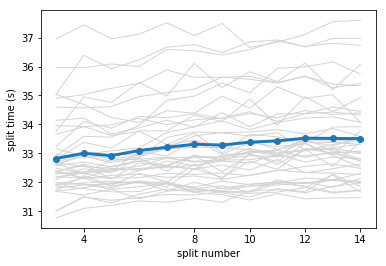

In [49]:
# Plot the splits for each swimmer
for splitset in splits:
    _ = plt.plot(split_number, splitset, linewidth=1, color='lightgray')

# Compute the mean split times
mean_splits = np.mean(splits, axis=0)

# Plot the mean split times
_ = plt.plot(split_number, mean_splits, marker='.', linewidth=3, markersize=12)

# Label axes and show plot
_ = plt.xlabel('split number')
_ = plt.ylabel('split time (s)')
plt.show()

## Linear regression of average split time

We will assume that the swimmers slow down in a linear fashion over the course of the 800 m event. The slowdown per split is then the slope of the mean split time versus split number plot. Perform a linear regression to estimate the slowdown per split and compute a pairs bootstrap 95% confidence interval on the slowdown. Also show a plot of the best fit line.

Note: We can compute error bars for the mean split times and use those in the regression analysis, but we will not take those into account here, as that is beyond the scope of this course.

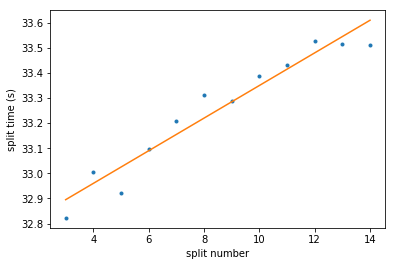


mean slowdown: 0.065 sec./split
95% conf int of mean slowdown: [0.051, 0.078] sec./split


In [50]:
# Perform regression
slowdown, split_3 = np.polyfit(split_number, mean_splits, 1)

# Compute pairs bootstrap
bs_reps, _ = dcst.draw_bs_pairs_linreg(split_number, mean_splits, size=10000)

# Compute confidence interval
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Plot the data with regressions line
_ = plt.plot(split_number, mean_splits, marker='.', linestyle='none')
_ = plt.plot(split_number, slowdown * split_number + split_3, '-')

# Label axes and show plot
_ = plt.xlabel('split number')
_ = plt.ylabel('split time (s)')
plt.show()

# Print the slowdown per split
print("""
mean slowdown: {0:.3f} sec./split
95% conf int of mean slowdown: [{1:.3f}, {2:.3f}] sec./split""".format(
    slowdown, *conf_int))


## Hypothesis test: are they slowing down?

Now we will test the null hypothesis that the swimmer's split time is not at all correlated with the distance they are at in the swim. We will use the Pearson correlation coefficient (computed using dcst.pearson_r()) as the test statistic.

In [51]:
# Observed correlation
rho = dcst.pearson_r(split_number, mean_splits)

# Initialize permutation reps
perm_reps_rho = np.empty(10000)

# Make permutation reps
for i in range(10000):
    # Scramble the split number array
    scrambled_split_number = np.random.permutation(split_number)
    
    # Compute the Pearson correlation coefficient
    perm_reps_rho[i] = dcst.pearson_r(scrambled_split_number, mean_splits)
    
# Compute and print p-value
p_val = np.sum(perm_reps_rho >= rho) / 10000
print('p =', p_val)

p = 0.0


# The "Current Controversy" of the 2013 World Championships

## A metric for improvement

In your first analysis, you will investigate how times of swimmers in 50 m events change as they move between low numbered lanes (1-3) to high numbered lanes (6-8) in the semifinals and finals. We showed in the previous chapter that there is little difference between semifinal and final performance, so you will neglect any differences due to it being the final versus the semifinal.

You want to use as much data as you can, so use all four strokes for both the men's and women's competitions. As such, what would be a good metric for improvement from one round to the next for an individual swimmer, where ta is the swim time in a low numbered lane and tb is the swim time in a high numbered lane?

## ECDF of improvement from low to high lanes

Now that you have a metric for improvement going from low- to high-numbered lanes, plot an ECDF of this metric. I have put together the swim times of all swimmers who swam a 50 m semifinal in a high numbered lane and the final in a low numbered lane, and vice versa. The swim times are stored in the Numpy arrays swimtime_high_lanes and swimtime_low_lanes. Entry i in the respective arrays are for the same swimmer in the same event.

In [54]:
swimtime_low_lanes = np.array([24.66, 23.28, 27.2 , 24.95, 32.34, 24.66, 26.17, 27.93, 23.35,
       22.93, 21.93, 28.33, 25.14, 25.19, 26.11, 31.31, 27.44, 21.85,
       27.48, 30.66, 21.74, 23.22, 27.93, 21.42, 24.79, 26.46])
swimtime_high_lanes = np.array([24.62, 22.9 , 27.05, 24.76, 30.31, 24.54, 26.12, 27.71, 23.15,
       23.11, 21.62, 28.02, 24.73, 24.95, 25.83, 30.61, 27.04, 21.67,
       27.16, 30.23, 21.51, 22.97, 28.05, 21.65, 24.54, 26.06])

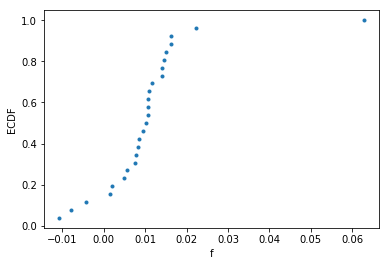

In [55]:
# Compute the fractional improvement of being in high lane: f
f = (swimtime_low_lanes - swimtime_high_lanes) / swimtime_low_lanes

# Make x and y values for ECDF: x, y
x, y = dcst.ecdf(f)

# Plot the ECDFs as dots
_ = plt.plot(x, y, marker='.', linestyle='none')

# Label the axes and show the plot
_ = plt.xlabel('f')
_ = plt.ylabel('ECDF')
plt.show()

## Estimation of mean improvement

You will now estimate how big this current effect is. Compute the mean fractional improvement for being in a high-numbered lane versus a low-numbered lane, along with a 95% confidence interval of the mean.

In [56]:
# Compute the mean difference: f_mean
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates: bs_reps
bs_reps = dcst.draw_bs_reps(f, np.mean, size=10000)

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Print the result
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))


mean frac. diff.: 0.01051
95% conf int of mean frac. diff.: [0.00615, 0.01583]


## How should we test the hypothesis?

You are interested in the presence of lane bias toward higher lanes, presumably due to a slight current in the pool. A natural null hypothesis to test, then, is that the mean fractional improvement going from low to high lane numbers is zero. Which of the following is a good way to simulate this null hypothesis?

As a reminder, the arrays swimtime_low_lanes and swimtime_high_lanes contain the swim times for lanes 1-3 and 6-8, respectively, and we define the fractional improvement as f = (swimtime_low_lanes - swimtime_high_lanes) / swimtime_low_lanes.

## Hypothesis test: Does lane assignment affect performance?

Perform a bootstrap hypothesis test of the null hypothesis that the mean fractional improvement going from low-numbered lanes to high-numbered lanes is zero. Take the fractional improvement as your test statistic, and "at least as extreme as" to mean that the test statistic under the null hypothesis is greater than or equal to what was observed.

In [57]:
# Shift f: f_shift
f_shift = f - f_mean

# Draw 100,000 bootstrap replicates of the mean: bs_reps
bs_reps = dcst.draw_bs_reps(f_shift, np.mean, size=100000)

# Compute and report the p-value
p_val = np.sum(bs_reps >= f_mean) / 100000
print('p =', p_val)

p = 0.00031


## Did the 2015 event have this problem?

You would like to know if this is a typical problem with pools in competitive swimming. To address this question, perform a similar analysis for the results of the 2015 FINA World Championships. That is, compute the mean fractional improvement for going from lanes 1-3 to lanes 6-8 for the 2015 competition, along with a 95% confidence interval on the mean. Also test the hypothesis that the mean fractional improvement is zero.

The arrays swimtime_low_lanes_15 and swimtime_high_lanes_15 have the pertinent data.

In [59]:
swimtime_low_lanes_15 = np.array([27.66, 24.69, 23.29, 23.05, 26.87, 31.03, 22.04, 24.51, 21.86,
       25.64, 25.91, 24.77, 30.14, 27.23, 24.31, 30.2 , 26.86])
swimtime_high_lanes_15 = np.array([27.7 , 24.64, 23.21, 23.09, 26.87, 30.74, 21.88, 24.5 , 21.86,
       25.9 , 26.2 , 24.73, 30.13, 26.92, 24.31, 30.25, 26.76])

In [60]:
# Compute f and its mean
f = (swimtime_low_lanes_15 - swimtime_high_lanes_15) / swimtime_low_lanes_15
f_mean = np.mean(f)

# Draw 10,000 bootstrap replicates
bs_reps = dcst.draw_bs_reps(f, np.mean, size=10000)

# Compute 95% confidence interval
conf_int = np.percentile(bs_reps, [2.5, 97.5])

# Shift f
f_shift = f - f_mean

# Draw 100,000 bootstrap replicates of the mean
bs_reps = dcst.draw_bs_reps(f_shift, np.mean, size=100000)

# Compute the p-value
p_val = np.sum(bs_reps >= f_mean) / 100000

# Print the results
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]
p-value: {3:.5f}""".format(f_mean, *conf_int, p_val))


mean frac. diff.: 0.00079
95% conf int of mean frac. diff.: [-0.00194, 0.00340]
p-value: 0.28489


## EDA: mean differences between odd and even splits

To investigate the differences between odd and even splits, you first need to define a difference metric. In previous exercises, you investigated the improvement of moving from a low-numbered lane to a high-numbered lane, defining f = (ta - tb) / ta. There, the ta in the denominator served as our reference time for improvement. Here, you are considering both improvement and decline in performance depending on the direction of swimming, so you want the reference to be an average. So, we will define the fractional difference as f = 2(ta - tb) / (ta + tb).

Your task here is to plot the mean fractional difference between odd and even splits versus lane number. I have already calculated the mean fractional differences for the 2013 and 2015 Worlds for you, and they are stored in f_13 and f_15. The corresponding lane numbers are in the array lanes.

In [62]:
lanes = np.array([1, 2, 3, 4, 5, 6, 7, 8])
f_13 = np.array([-0.01562214, -0.0146381 , -0.00977673, -0.00525713,  0.00204104,
        0.00381014,  0.0075664 ,  0.01525869])
f_15 = np.array([-0.00516018, -0.00392952, -0.00099284,  0.00059953, -0.002424  ,
       -0.00451099,  0.00047467,  0.00081962])

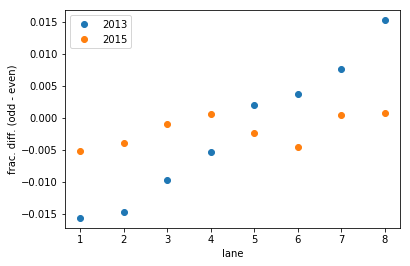

In [63]:
# Plot the the fractional difference for 2013 and 2015
_ = plt.plot(lanes, f_13, marker='.', markersize=12, linestyle='none')
_ = plt.plot(lanes, f_15, marker='.', markersize=12, linestyle='none')

# Add a legend
_ = plt.legend((2013, 2015))

# Label axes and show plot
_ = plt.xlabel('lane')
_ = plt.ylabel('frac. diff. (odd - even)')
plt.show()

## How does the current effect depend on lane position?

To quantify the effect of lane number on performance, perform a linear regression on the f_13 versus lanes data. Do a pairs bootstrap calculation to get a 95% confidence interval. Finally, make a plot of the regression. The arrays lanes and f_13 are in your namespace.

Note that we could compute error bars on the mean fractional differences and use them in the regression, but that is beyond the scope of this course.


slope: 0.00447 per lane
95% conf int: [0.00392, 0.00501] per lane


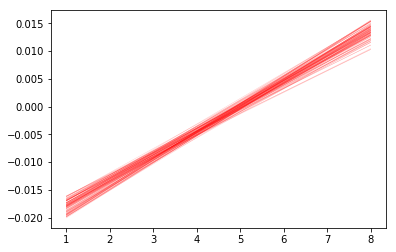

In [64]:
# Compute the slope and intercept of the frac diff/lane curve
slope, intercept = np.polyfit(lanes, f_13, 1)

# Compute bootstrap replicates
bs_reps_slope, bs_reps_int = dcst.draw_bs_pairs_linreg(lanes, f_13, size=10000)

# Compute 95% confidence interval of slope
conf_int = np.percentile(bs_reps_slope, [2.5, 97.5])

# Print slope and confidence interval
print("""
slope: {0:.5f} per lane
95% conf int: [{1:.5f}, {2:.5f}] per lane""".format(slope, *conf_int))

# x-values for plotting regression lines
x = np.array([1, 8])

# Plot 100 bootstrap replicate lines
for i in range(100):
    _ = plt.plot(x, bs_reps_slope[i] * x + bs_reps_int[i], 
                 color='red', alpha=0.2, linewidth=0.5)
   
# Update the plot
plt.draw()
plt.show()

## Hypothesis test: can this be by chance?

The EDA and linear regression analysis is pretty conclusive. Nonetheless, you will top off the analysis of the zigzag effect by testing the hypothesis that lane assignment has nothing to do with the mean fractional difference between even and odd lanes using a permutation test. You will use the Pearson correlation coefficient, which you can compute with dcst.pearson_r() as the test statistic. The variables lanes and f_13 are already in your namespace.

In [65]:
# Compute observed correlation: rho
rho = dcst.pearson_r(lanes, f_13)

# Initialize permutation reps: perm_reps_rho
perm_reps_rho = np.empty(10000)

# Make permutation reps
for i in range(10000):
    # Scramble the lanes array: scrambled_lanes
    scrambled_lanes = np.random.permutation(lanes)
    
    # Compute the Pearson correlation coefficient
    perm_reps_rho[i] = dcst.pearson_r(scrambled_lanes, f_13)
    
# Compute and print p-value
p_val = np.sum(perm_reps_rho >= rho) / 10000
print('p =', p_val)

p = 0.0


# Statistical seismology and the Parkfield region

## Parkfield earthquake magnitudes

As usual, you will start with EDA and plot the ECDF of the magnitudes of earthquakes detected in the Parkfield region from 1950 to 2016. The magnitudes of all earthquakes in the region from the ANSS ComCat are stored in the Numpy array mags.

When you do it this time, though, take a shortcut in generating the ECDF. You may recall that putting an asterisk before an argument in a function splits what follows into separate arguments. Since dcst.ecdf() returns two values, we can pass them as the x, y positional arguments to plt.plot() as plt.plot(*dcst.ecdf(data_you_want_to_plot)).

You will use this shortcut in this exercise and going forward.

In [67]:
mags = np.loadtxt('27Data4.txt', delimiter=',')

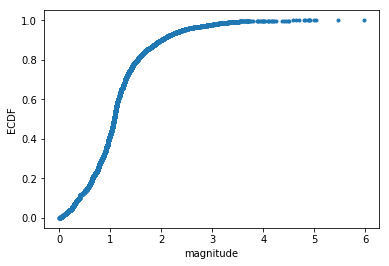

In [68]:
# Make the plot
_ = plt.plot(*dcst.ecdf(mags), marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
plt.show()

## Computing the b-value

The b-value is a common metric for the seismicity of a region. You can imagine you would like to calculate it often when working with earthquake data. For tasks like this that you will do often, it is best to write a function! So, write a function with signature b_value(mags, mt, perc=[2.5, 97.5], n_reps=None) that returns the b-value and (optionally, if n_reps is not None) its confidence interval for a set of magnitudes, mags. The completeness threshold is given by mt. The perc keyword argument gives the percentiles for the lower and upper bounds of the confidence interval, and n_reps is the number of bootstrap replicates to use in computing the confidence interval.

In [69]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]

    # Compute b-value: b
    b = (np.mean(m) - mt) * np.log(10)

    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, size=n_reps)

        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
    
        return b, conf_int

## The b-value for Parkfield

The ECDF is effective at exposing roll-off, as you could see below magnitude 1. Because there are plenty of earthquakes above magnitude 3, you can use mt = 3 as your completeness threshold. With this completeness threshold, compute the b-value for the Parkfield region from 1950 to 2016, along with the 95% confidence interval. Print the results to the screen. The variable mags with all the magnitudes is in your namespace.

Overlay the theoretical Exponential CDF to verify that the Parkfield region follows the Gutenberg-Richter Law.

In [71]:
mt = 3

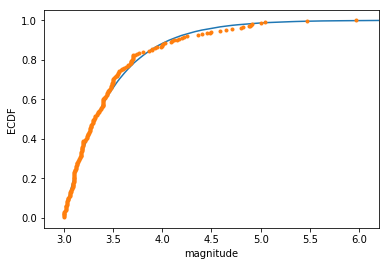


b-value: 1.08
95% conf int: [0.94, 1.24]


In [72]:
# Compute b-value and confidence interval
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

# Generate samples to for theoretical ECDF
m_theor = np.random.exponential(b/np.log(10), size=100000) + mt

# Plot the theoretical CDF
_ = plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF (slicing mags >= mt)
_ = plt.plot(*dcst.ecdf(mags[mags >= mt]), marker='.', linestyle='none')

# Pretty up and show the plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(2.8, 6.2)
plt.show()

# Report the results
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

## Interearthquake time estimates for Parkfield

In this exercise, you will first compute the best estimates for the parameters for the Exponential and Gaussian models for interearthquake times. You will then plot the theoretical CDFs for the respective models along with the formal ECDF of the actual Parkfield interearthquake times.

In [74]:
time_gap = np.array([24.06570842, 20.07665982, 21.01848049, 12.24640657, 32.05475702,
       38.2532512 ])

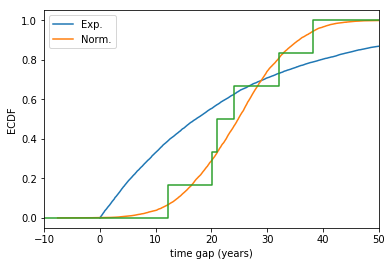

In [75]:
# Compute the mean time gap: mean_time_gap
mean_time_gap = np.mean(time_gap)

# Standard deviation of the time gap: std_time_gap
std_time_gap = np.std(time_gap)

# Generate theoretical Exponential distribution of timings: time_gap_exp
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

# Generate theoretical Normal distribution of timings: time_gap_norm
time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Plot theoretical CDFs
_ = plt.plot(*dcst.ecdf(time_gap_exp))
_ = plt.plot(*dcst.ecdf(time_gap_norm))

# Plot Parkfield ECDF
_ = plt.plot(*dcst.ecdf(time_gap, formal=True, min_x=-10, max_x=50))

# Add legend
_ = plt.legend(('Exp.', 'Norm.'), loc='upper left')

# Label axes, set limits and show plot
_ = plt.xlabel('time gap (years)')
_ = plt.ylabel('ECDF')
_ = plt.xlim(-10, 50)
plt.show()

## When will the next big Parkfield quake be?

The last big earthquake in the Parkfield region was on the evening of September 27, 2004 local time. Your task is to get an estimate as to when the next Parkfield quake will be, assuming the Exponential model and also the Gaussian model. In both cases, the best estimate is given by the mean time gap, which you computed in the last exercise to be 24.62 years, meaning that the next earthquake would be in 2029. Compute 95% confidence intervals on when the next earthquake will be assuming an Exponential distribution parametrized by mean_time_gap you computed in the last exercise. Do the same assuming a Normal distribution parametrized by mean_time_gap and std_time_gap.

In [79]:
today = 2019.1296331239814
last_quake = 2004.74

In [80]:
# Draw samples from the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# Draw samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(mean_time_gap, std_time_gap, size=100000)

# No earthquake as of today, so only keep samples that are long enough
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

# Compute the confidence intervals with medians
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

# Print the results
print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)

Exponential: [2019.73162777 2036.25166373 2109.30201296]
     Normal: [2020.01756393 2030.54354152 2046.33495463]


## Computing the value of a formal ECDF

To be able to do the Kolmogorov-Smirnov test, we need to compute the value of a formal ECDF at arbitrary points. In other words, we need a function, ecdf_formal(x, data) that returns the value of the formal ECDF derived from the data set data for each value in the array x. Two of the functions accomplish this. One will not. Of the two that do the calculation correctly, one is faster. Label each.

As a reminder, the ECDF is formally defined as ECDF(x) = (number of samples ≤ x) / (total number of samples). You also might want to check out the doc string of np.searchsorted().

a)

    def ecdf_formal(x, data):
        return np.searchsorted(np.sort(data), x) / len(data)

b)

    def ecdf_formal(x, data):
        return np.searchsorted(np.sort(data), x, side='right') / len(data)

c)

    def ecdf_formal(x, data):
        output = np.empty(len(x))
        data = np.sort(data)
        for i, x_val in x:
            j = 0
            while j < len(data) and x_val >= data[j]:
                j += 1
            output[i] = j
        return output / len(data)


## Computing the K-S statistic

Write a function to compute the Kolmogorov-Smirnov statistic from two data sets, data1 and data2. In practice using hacker stats, the second data set will be samples from the theoretical distribution you are comparing your data to. Conveniently, the function you just selected for computing values of the formal ECDF is given as dcst.ecdf_formal().

In [81]:
def ks_stat(data1, data2):
    # Compute ECDF from data: x, y
    x, y = dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = dcst.ecdf_formal(x, data2)

    # Compute distances between concave corners and CDF
    D_top = y - cdf

    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1/len(data1)

    return np.max((D_top, D_bottom))

## Drawing K-S replicates

Now, you need a function to draw Kolmogorov-Smirnov replicates out of a target distribution, f. Construct a function with signature draw_ks_reps(n, f, args=(), size=10000, n_reps=10000) to do so. Here, n is the number of data points, and f is the function you will use to generate samples from the target CDF. For example, to test against an Exponential distribution, you would pass np.random.exponential as f. This function usually takes arguments, which must be passed as a tuple. So, if you wanted to take samples from an Exponential distribution with mean x_mean, you would use the args=(x_mean,) keyword. The keyword arguments size and n_reps respectively represent the number of samples to take from the target distribution and the number of replicates to draw.

In [82]:
def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
    # Generate samples from target distribution
    x_f = f(*args, size=size)
    
    # Initialize K-S replicates
    reps = np.empty(n_reps)
    
    # Draw replicates
    for i in range(n_reps):
        # Draw samples for comparison
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = dcst.ks_stat(x_samp, x_f)

    return reps

## The K-S test for Exponentiality

Test the null hypothesis that the interearthquake times of the Parkfield sequence are Exponentially distributed. That is, earthquakes happen at random with no memory of when the last one was. Note: This calculation is computationally intensive (you will draw more than 108 random numbers), so it will take about 10 seconds to complete.

In [83]:
# Draw target distribution: x_f
x_f = np.random.exponential(mean_time_gap, size=10000)

# Compute K-S stat: d
d = dcst.ks_stat(time_gap, x_f)

# Draw K-S replicates: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('p =', p_val)

p = 0.2526


# Earthquakes and oil mining in Oklahoma

## EDA: Plotting earthquakes over time

Make a plot where the y-axis is the magnitude and the x-axis is the time of all earthquakes in Oklahoma between 1980 and the first half of 2017. Each dot in the plot represents a single earthquake. The time of the earthquakes, as decimal years, is stored in the Numpy array time, and the magnitudes in the Numpy array mags.

In [87]:
time = np.loadtxt('27Data5.txt', delimiter=',')
mags = np.loadtxt('27Data6.txt', delimiter=',')

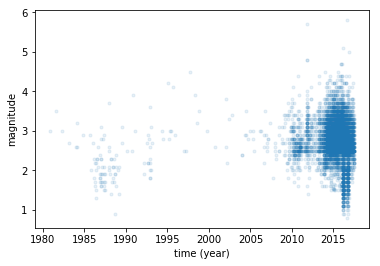

In [88]:
# Plot time vs. magnitude
_ = plt.plot(time, mags, marker='.', linestyle='none', alpha=0.1)

# Label axes and show the plot
_ = plt.xlabel('time (year)')
_ = plt.ylabel('magnitude')
plt.show()

## Estimates of the mean interearthquake times

The graphical EDA in the last exercise shows an obvious change in earthquake frequency around 2010. To compare, compute the mean time between earthquakes of magnitude 3 and larger from 1980 through 2009 and also from 2010 through mid-2017. Also include 95% confidence intervals of the mean. The variables dt_pre and dt_post respectively contain the time gap between all earthquakes of magnitude at least 3 from pre-2010 and post-2010 in units of days.

In [90]:
dt_pre = np.array([2.51473603e+02, 2.95650596e+02, 6.41211817e+02, 1.08631328e+03,
       3.17616277e+02, 5.89587696e+02, 4.83564906e+02, 6.97670295e+01,
       6.92609789e+02, 2.83876828e+01, 4.69754032e+02, 2.64696924e+02,
       7.66216207e+01, 5.70100061e+01, 1.05893359e+02, 7.22457315e+02,
       2.33767653e+02, 7.02367640e+01, 1.15034729e+02, 3.60481877e+02,
       8.36271879e+02, 1.11819550e+02, 1.41778326e+02, 5.96888641e+02,
       1.67632908e+02, 1.50228765e+02, 3.27358344e+02, 2.14424228e+01,
       1.84269802e+02, 2.33111006e+02, 3.78900412e+02, 1.42433380e+02,
       8.96787214e+01, 5.96520032e+00, 1.89851791e+01, 2.77352546e+00,
       1.13775168e+01, 9.84176998e+01, 1.20027146e+01, 4.83078902e+00,
       2.03967335e+01, 3.62722197e+01, 7.41380943e-01, 5.61129875e+01,
       2.23184198e+01, 2.00108958e+00, 7.00255109e-01, 1.19086239e+01,
       8.67777468e+00, 4.74607571e+00, 8.78615616e-01, 6.85672396e+00])
dt_post = np.loadtxt('27Data7.txt', delimiter=',')

In [91]:
# Compute mean interearthquake time
mean_dt_pre = np.mean(dt_pre)
mean_dt_post = np.mean(dt_post)

# Draw 10,000 bootstrap replicates of the mean
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post, np.mean, size=10000)

# Compute the confidence interval
conf_int_pre = np.percentile(bs_reps_pre, [2.5, 97.5])
conf_int_post = np.percentile(bs_reps_post, [2.5, 97.5])

# Print the results
print("""1980 through 2009
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_pre, *conf_int_pre))

print("""
2010 through mid-2017
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_post, *conf_int_post))

1980 through 2009
mean time gap: 204.61 days
95% conf int: [139.15, 276.11] days

2010 through mid-2017
mean time gap: 1.12 days
95% conf int: [0.97, 1.29] days


## Hypothesis test: did earthquake frequency change?

Obviously, there was a massive increase in earthquake frequency once wastewater injection began. Nonetheless, you will still do a hypothesis test for practice. You will not test the hypothesis that the interearthquake times have the same distribution before and after 2010, since wastewater injection may affect the distribution. Instead, you will assume that they have the same mean. So, compute the p-value associated with the hypothesis that the pre- and post-2010 interearthquake times have the same mean, using the mean of pre-2010 time gaps minus the mean of post-2010 time gaps as your test statistic.

In [92]:
# Compute the observed test statistic
mean_dt_diff = mean_dt_pre - mean_dt_post

# Shift the post-2010 data to have the same mean as the pre-2010 data
dt_post_shift = dt_post - mean_dt_post + mean_dt_pre

# Compute 10,000 bootstrap replicates from arrays
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post_shift, np.mean, size=10000)

# Get replicates of difference of means
bs_reps = bs_reps_pre - bs_reps_post

# Compute and print the p-value
p_val = np.sum(bs_reps >= mean_dt_diff) / 10000
print('p =', p_val)

p = 0.0


## EDA: Comparing magnitudes before and after 2010

Make an ECDF of earthquake magnitudes from 1980 through 2009. On the same plot, show an ECDF of magnitudes of earthquakes from 2010 through mid-2017. The time of the earthquakes, as decimal years, are stored in the Numpy array time and the magnitudes in the Numpy array mags.

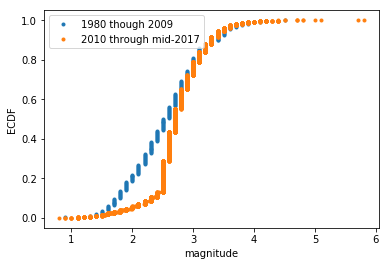

In [93]:
# Get magnitudes before and after 2010
mags_pre = mags[time < 2010]
mags_post = mags[time >= 2010]

# Generate ECDFs
_ = plt.plot(*dcst.ecdf(mags_pre), marker='.', linestyle='none')
_ = plt.plot(*dcst.ecdf(mags_post), marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
plt.legend(('1980 though 2009', '2010 through mid-2017'), loc='upper left')
plt.show()

## Quantification of the b-values

Based on the plot you generated in the previous exercise, you can safely use a completeness threshold of mt = 3. Using this threshold, compute b-values for the period between 1980 and 2009 and for 2010 through mid-2017. The function b_value() you wrote last chapter, which computes the b-value and confidence interval from a set of magnitudes and completeness threshold, is available in your namespace, as are the numpy arrays mags_pre and mags_post from the last exercise, and mt.

In [94]:
# Compute b-value and confidence interval for pre-2010
b_pre, conf_int_pre = b_value(mags_pre, mt, perc=[2.5, 97.5], n_reps=10000)

# Compute b-value and confidence interval for post-2010
b_post, conf_int_post = b_value(mags_post, mt, perc=[2.5, 97.5], n_reps=10000)

# Report the results
print("""
1980 through 2009
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]

2010 through mid-2017
b-value: {3:.2f}
95% conf int: [{4:.2f}, {5:.2f}]
""".format(b_pre, *conf_int_pre, b_post, *conf_int_post))



1980 through 2009
b-value: 0.74
95% conf int: [0.54, 0.96]

2010 through mid-2017
b-value: 0.62
95% conf int: [0.60, 0.65]



## Hypothesis test: are the b-values different?

Perform the hypothesis test sketched out on the previous exercise. The variables mags_pre and mags_post are already loaded into your namespace, as is mt = 3.

In [95]:
# Only magnitudes above completeness threshold
mags_pre = mags_pre[mags_pre >= mt]
mags_post = mags_post[mags_post >= mt]

# Observed difference in mean magnitudes: diff_obs
diff_obs = np.mean(mags_post) - np.mean(mags_pre)

# Generate permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(mags_post, mags_pre, dcst.diff_of_means, size=10000)

# Compute and print p-value
p_val = np.sum(perm_reps < diff_obs) / 10000
print('p =', p_val)

p = 0.1047


## What can you conclude from this analysis?

All but one of the following constitute reasonable conclusions from our analysis of earthquakes. Which one does not?

    ## Parkfield 1950 through 2009
    b-value: 1.08
    95% conf int: [0.94, 1.23]


    Oklahoma 1980 through 2009
    b-value: 0.74
    95% conf int: [0.54, 0.97]

    mean time gap: 204.61 days
    95% conf int: [138.45, 276.83] days


    Oklahoma 2010 through mid-2017
    b-value: 0.62
    95% conf int: [0.60, 0.65]

    mean time gap: 1.12 days
    95% conf int: [0.97, 1.30] days


    Oklahoma: p-value for difference in b-value : 0.10